In [1]:
# !pip install -qU git+https://github.com/leauferreira/GpX
# !pip install gplearn

In [1]:
import numpy as np
from IPython.display import Image
from gp_explainer.gpx import Gpx
import xgboost as xgb

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# diabetes_data = pd.read_csv("pydm/data/diabetes.csv")
# diabetes_data["class"] = np.where(diabetes_data["class"] == "tested_positive", 1, 0)

diabetes_data = pd.read_csv("diabetes_data.csv")
diabetes_data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,class
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [93]:
# x = diabetes_data[['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']]
x = diabetes_data.drop('class', axis=1).to_numpy()
y = diabetes_data['class'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, test_size=.2)

In [94]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',         # Evaluation metric: log loss
    'eta': 0.1,                        # Learning rate
    'max_depth': 3,                    # Maximum tree depth
    'subsample': 0.8,                  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,           # Subsample ratio of columns when constructing each tree
    'seed': 42                         # Random seed for reproducibility
}

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Train the XGBoost model
num_round = 100  # Number of boosting rounds (iterations)
model = xgb.train(params, dtrain, num_round)

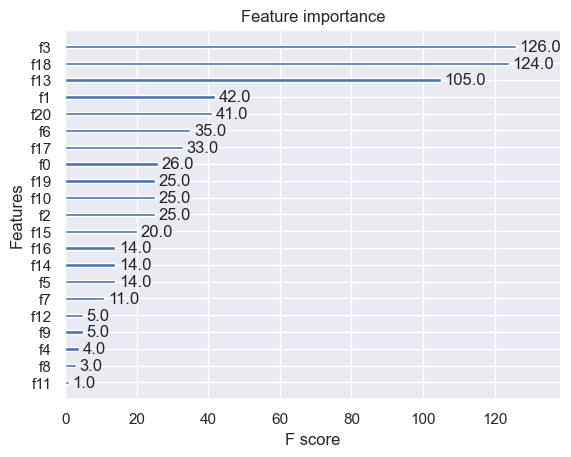

In [95]:
xgb.plot_importance(model, importance_type="weight")
sns.set_theme(style="darkgrid")

plt.show()

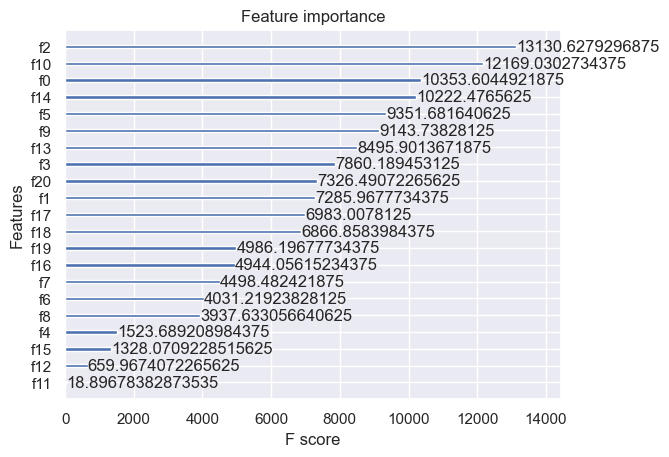

In [96]:
xgb.plot_importance(model, importance_type="cover")
plt.show()

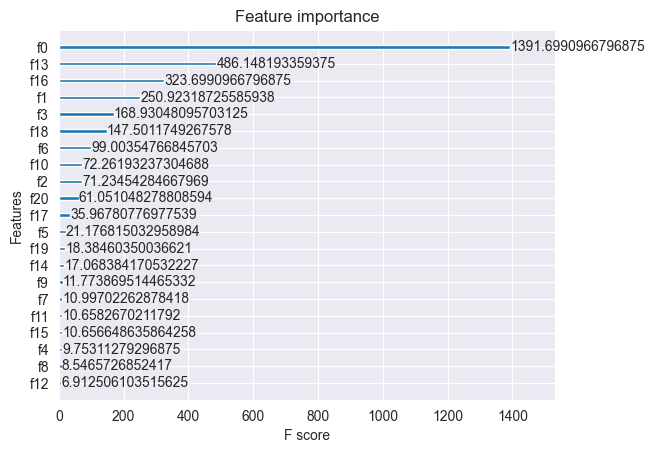

In [7]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

In [160]:
np.random.seed(1086)
instance = x_test[np.random.randint(x_test.shape[0]), :]
# model.fit(x_train, y_train.ravel())

In [161]:
instance

array([ 1,  1,  1, 22,  0,  0,  0,  1,  1,  0,  0,  1,  0,  2,  0,  0,  0,
        0, 10,  4,  7], dtype=int64)

In [162]:
gpx = Gpx(model.predict, x_train=x_train, y_train=y_train, num_samples=100)

In [163]:
my_exp = gpx.explaining(instance)

## Understand
We say that an explainer, $f$, "understands" the complex model, $g$, if its error on the noise set, $\eta$, relative to the complex model predictions is small.  For regression problems, this concept may be translated into the Root Mean Squared Error between the model and the explainer as follows:

$$
    u_r(f) =   \frac{1}{|\eta|} \sum_{\mathbf{s}_i \in \eta} (f(\mathbf{s}_i) - g(\mathbf{s}_i) )^2
$$

For classification problems, it may be formalized as the accuracy of the explainer with respect to the complex models predictions.

$$
     u_c(f) =   \frac{1}{|\eta|} \sum_{\mathbf{s}_i \in \eta} h(\mathbf{s_i})
$$

where:
$$
h(\mathbf{s}_i) = \begin{cases}
1 & \text{ if } f(\mathbf{s}_i) = g(\mathbf{s}_i)\\
0 & \text{ if } f(\mathbf{s}_i) \neq g(\mathbf{s}_i)
\end{cases}
$$

In [164]:
acc = gpx.understand(metric='report')
print("gpx understands the black-box model with accuracy: {}".format(acc))

gpx understands the black-box model with accuracy: {'accuracy': 1.0, 'f1': 1.0}


## Features distribution


dict_values([1, 9, 0, 2, 0, 0, 1, 2, 0, 0, 3, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0])

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

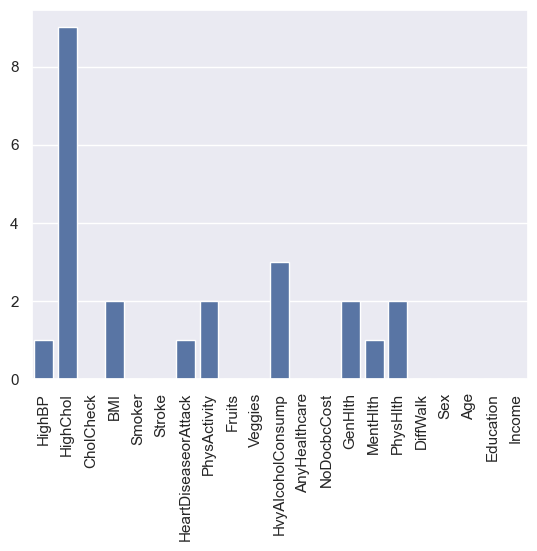

In [165]:
fd = gpx.features_distribution()

display(fd.values())
display(diabetes_data.columns[:-1])

sns.barplot(x=list(diabetes_data.columns[:-1]), y=list(fd.values()))
sns.set_theme(style="darkgrid")
plt.xticks(rotation=90)
plt.show()

In [14]:
graph = gpx.make_graphviz_model()

Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [54]:
diabetes_data.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'class'],
      dtype='object')

# SHAP Integration

In [15]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/39/6c/4ab39615fc3ffe40faaa62fc2feb43868b8ce946c671e84bf476c1e06116/shap-0.45.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.7 from https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/38/f0/ad848815b0adafcf5f238e728933950034355a8d59969772be1cd57606d8/numba-0.59.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.43,>=0.42.0dev0 from https://files.pythonhosted.org/packages/f3/bd/3b27a1c8bbbe01b053f5e0c9ca9a37dbc3e39282dfcf596d143ad389f156/llv


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 187.9 kB/s eta 0:00:02
     ---- -------------------------------- 30.7/275.7 kB 187.9 kB/s eta 0:00:02
     ---- -------------------------------- 30.7/275.7 kB 187.9 kB/s eta 0:00:02
     -------- ---------------------------- 61.4/275.7 kB 193.2 kB/s eta 0:00:02
     ---------- -------------------------- 81.9/275.7 kB 241.3 kB/s eta 0:00:01
     -------------- --------------------- 112.6/275.7 kB 285.2 kB/s eta 0:00:01
     -------------- --------------------- 112.6/275.7 kB 285.2 kB/s eta 0:00:01
     ------------------ ----------------- 143.4/275.7 kB 304.6 kB/s eta 0:00:01
     ---------------------- ------------- 174.1/275.7 kB 338.5 kB/s eta 0:00:01
     -------------------------- --------- 204.8/275.7 kB 37


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


100%|===================| 202735/202944 [05:13<00:00]        

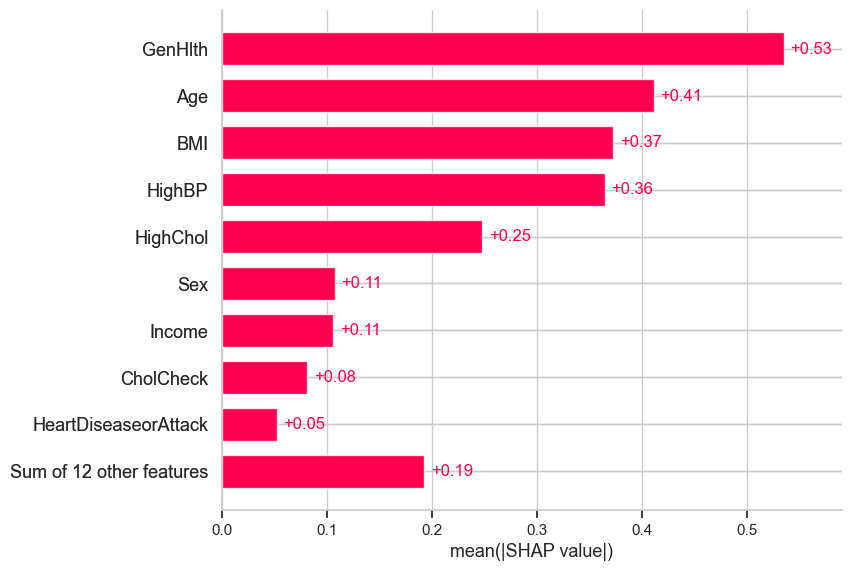

In [68]:
import shap

# SHAP Explanation
shap_explainer = shap.Explainer(model, x_train)
shap_values = shap_explainer(x_train)

shap.plots.bar(shap_values)

[1.0454545454545454, 5.2272727272727275, 0.5227272727272727, 1.5681818181818181, 0.5227272727272727, 0.5227272727272727, 1.0454545454545454, 1.5681818181818181, 0.5227272727272727, 0.5227272727272727, 2.090909090909091, 0.5227272727272727, 0.5227272727272727, 1.5681818181818181, 1.0454545454545454, 1.5681818181818181, 0.5227272727272727, 0.5227272727272727, 0.5227272727272727, 0.5227272727272727, 0.5227272727272727]


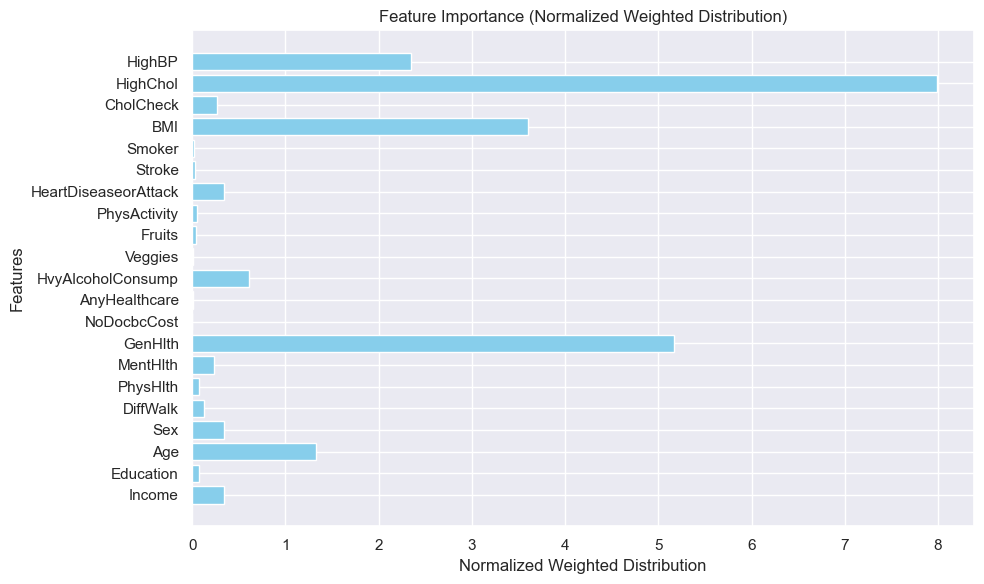

In [166]:
# Apply Laplace smoothing to the GPX feature distribution
# Add 1 to each count to account for 0 values
smoothed_distribution = [count + 1 for count in fd.values()]


# Normalize the smoothed distribution so that it sums up to the original total count
total_count_with_smoothing = sum(smoothed_distribution)
normalized_smoothed_distribution = [count / total_count_with_smoothing * sum(fd.values()) for count in smoothed_distribution]
print(normalized_smoothed_distribution)

shap_weights = np.abs(shap_values.values).mean(0)
# Normalize the SHAP weights
normalized_shap_weights = [weight / sum(shap_weights) for weight in shap_weights]

# Multiply the GPX distribution by the normalized SHAP weights
weighted_distribution = [count * weight for count, weight in zip(normalized_smoothed_distribution, normalized_shap_weights)]

# Re-normalize the resulting distribution
total_count = sum(normalized_smoothed_distribution)
normalized_weighted_distribution = [count / sum(weighted_distribution) * total_count for count in weighted_distribution]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(diabetes_data.columns[:-1], normalized_weighted_distribution, color='skyblue')
plt.xlabel('Normalized Weighted Distribution')
plt.ylabel('Features')
plt.title('Feature Importance (Normalized Weighted Distribution)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show the plot
plt.tight_layout()
plt.show()
